In [1]:
import numpy as np
import pandas as pd
import os
import gc
import random
random.seed(1024)

In [2]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from IPython.display import display

# Gradient Boosting
import lightgbm as lgb

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

In [3]:
id_col = "ID"
target_var = "target"

print("Loading Data...")
df_train = pd.read_csv("./train.csv", index_col=id_col)
training_index = df_train.index
df_test = pd.read_csv("./test.csv", index_col=id_col)
test_index = df_test.index

y = np.log1p(df_train[target_var])
df_train.drop(target_var, axis=1, inplace=True)

print('Train shape: {} Rows, {} Columns'.format(*df_train.shape))
print('Test shape: {} Rows, {} Columns'.format(*df_test.shape))

print("Combine Train and Test")
df = pd.concat([df_train, df_test], axis=0)
del df_train, df_test
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Loading Data...
Train shape: 4459 Rows, 4991 Columns
Test shape: 49342 Rows, 4991 Columns
Combine Train and Test

All Data shape: 53801 Rows, 4991 Columns


In [4]:
# Modeling Datasets
test_df = df.loc[test_index,:]
vocab = df.columns

# LGBM Dataset
lgtrain = lgb.Dataset(df.loc[training_index,vocab],y ,feature_name = "auto")
print("Starting LightGBM. Train shape: {}, Test shape: {}".format(df.loc[training_index,:].shape,test_df.shape))
print("Feature Num: ",len(vocab))
del df; gc.collect();

Starting LightGBM. Train shape: (4459, 4991), Test shape: (49342, 4991)
Feature Num:  4991


In [5]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 180,
    "feature_fraction": 0.50,
    "bagging_fraction": 0.50,
    'bagging_freq': 4,
    "max_depth": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.1,
    #"min_split_gain":0.2,
    "min_child_weight":10,
    'zero_as_missing':True,
    'device': 'gpu',
                }

In [6]:
results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(
    params = lgbm_params,
    train_set = lgtrain,
    num_boost_round=2000,
    stratified=False,
    nfold = 5,
    verbose_eval=50,
    seed = 23,
    early_stopping_rounds=75)

optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
best_cv_score = min(lgb_cv['rmse-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds,best_cv_score,lgb_cv['rmse-stdv'][optimal_rounds]))

results = results.append({"Rounds": optimal_rounds,
                          "Score": best_cv_score,
                          "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                          "LB": None,
                          "Parameters": lgbm_params}, ignore_index=True)

[50]	cv_agg's rmse: 1.58741 + 0.0306311
[100]	cv_agg's rmse: 1.50443 + 0.0318075
[150]	cv_agg's rmse: 1.46284 + 0.0331831
[200]	cv_agg's rmse: 1.44236 + 0.0335287
[250]	cv_agg's rmse: 1.43341 + 0.034419
[300]	cv_agg's rmse: 1.43014 + 0.0353831
[350]	cv_agg's rmse: 1.42831 + 0.0354467
[400]	cv_agg's rmse: 1.42878 + 0.0358922

Optimal Round: 354
Optimal Score: 1.4282862001526841 + 0.03544504088159813


In [7]:
pd.set_option('max_colwidth', 800)
display(results.sort_values(by="Score",ascending = True))

,Rounds,Score,STDV,LB,Parameters
0,354,1.428286,0.035445,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'device': 'gpu', 'verbose': 1}"


In [ ]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

results = pd.DataFrame(columns = ["Rounds","Score","STDV", "Parameters"])

def objective(params):
    lgbm_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        "learning_rate": 0.005,
        "num_leaves": 180,
        "feature_fraction": 0.50,
        "bagging_fraction": 0.50,
        'bagging_freq': 4,
        "max_depth": -1,
        "reg_alpha": 0.3,
        "reg_lambda": 0.1,
        #"min_split_gain":0.2,
        "min_child_weight":10,
        'zero_as_missing':True,
        'device': 'gpu',
    }
    
    params['num_leaves'] = int(params['num_leaves'])
    params['colsample_bytree'] = '{:.3f}'.format(params['colsample_bytree'])
    cv_params = dict(lgbm_params, **params)
    
    lgb_cv = lgb.cv(
        params = cv_params,
        train_set = lgtrain,
        num_boost_round=2000,
        stratified=False,
        nfold = 3,
        verbose_eval=10000,
        seed = 1234,
        early_stopping_rounds=75)
    
    score = np.min(lgb_cv['rmse-mean'])
    optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
    print("Params: {}".format(params))
    print("Optimal Round: {}\nOptimal Score: {} + {}".format(
        optimal_rounds,score,lgb_cv['rmse-stdv'][optimal_rounds]))
    global results
    results = results.append({"Rounds": optimal_rounds,
                          "Score": score,
                          "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                          "Parameters": params}, ignore_index=True)
    print("###########################################################################################")

    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 40, 320, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'max_depth': hp.choice('max_depth', [-1,4,6,8,12,16,24,32]),
    'num_leaves': hp.choice('num_leaves', [12, 16,36,48,60,80,100])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500)

Params: {'colsample_bytree': '0.889', 'max_depth': 6, 'num_leaves': 12}
Optimal Round: 1239
Optimal Score: 1.444767365692693 + 0.01178028593554939
###########################################################################################
Params: {'colsample_bytree': '0.307', 'max_depth': 24, 'num_leaves': 100}
Optimal Round: 767
Optimal Score: 1.428170397403551 + 0.0065255425954666695
###########################################################################################
Params: {'colsample_bytree': '0.867', 'max_depth': 4, 'num_leaves': 48}
Optimal Round: 1986
Optimal Score: 1.4469565230123955 + 0.01140976123797393
###########################################################################################
Params: {'colsample_bytree': '0.519', 'max_depth': 16, 'num_leaves': 48}
Optimal Round: 878
Optimal Score: 1.4300856543015936 + 0.006637977147080361
###########################################################################################
Params: {'colsample_bytree': '0.461', 

In [8]:
learning_rates = [0.05, 0.02, 0.01 ,0.005]
for param in learning_rates:
    print("Learning Rate: ", param)
    lgbm_params["learning_rate"] = param
    # Find Optimal Parameters / Boosting Rounds
    lgb_cv = lgb.cv(
        params = lgbm_params,
        train_set = lgtrain,
        num_boost_round=10000,
        stratified=False,
        nfold = 5,
        verbose_eval=200,
        seed = 23,
        early_stopping_rounds=75)

    optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
    best_cv_score = min(lgb_cv['rmse-mean'])

    print("Optimal Round: {}\nOptimal Score: {} + {}".format(
        optimal_rounds,best_cv_score,lgb_cv['rmse-stdv'][optimal_rounds]))
    print("###########################################################################################")

    results = results.append({"Rounds": optimal_rounds,
                              "Score": best_cv_score,
                              "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                              "LB": None,
                              "Parameters": lgbm_params}, ignore_index=True)

Learning Rate:  0.05
Optimal Round: 67
Optimal Score: 1.440610178715214 + 0.034797090743399185
###########################################################################################
Learning Rate:  0.02
[200]	cv_agg's rmse: 1.42812 + 0.0339248
Optimal Round: 189
Optimal Score: 1.4278403146994678 + 0.03348877454276888
###########################################################################################
Learning Rate:  0.01
[200]	cv_agg's rmse: 1.4424 + 0.0321967
[400]	cv_agg's rmse: 1.42841 + 0.0338602
Optimal Round: 354
Optimal Score: 1.4280965633533496 + 0.03296058720274084
###########################################################################################
Learning Rate:  0.005
[200]	cv_agg's rmse: 1.50432 + 0.0307107
[400]	cv_agg's rmse: 1.44214 + 0.0336777
[600]	cv_agg's rmse: 1.42859 + 0.0348327
[800]	cv_agg's rmse: 1.42742 + 0.0341657
Optimal Round: 727
Optimal Score: 1.4273314415929181 + 0.0340931405043055
#######################################################

In [9]:
pd.set_option('max_colwidth', 800)
display(results.sort_values(by="Score",ascending = True))

,Rounds,Score,STDV,LB,Parameters
4,727,1.427331,0.034093,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.005, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'device': 'gpu', 'verbose': 1}"
2,189,1.427840,0.033489,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.005, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'device': 'gpu', 'verbose': 1}"
3,354,1.428097,0.032961,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.005, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'device': 'gpu', 'verbose': 1}"
0,354,1.428286,0.035445,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.005, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'device': 'gpu', 'verbose': 1}"
1,67,1.440610,0.034797,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.005, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'device': 'gpu', 'verbose': 1}"


In [10]:
# Best Parameters
final_model_params = results.iloc[results["Score"].idxmin(),:]["Parameters"]
optimal_rounds = results.iloc[results["Score"].idxmin(),:]["Rounds"]
print("Parameters for Final Models:\n",final_model_params)
print("Score: {} +/- {}".format(results.iloc[results["Score"].idxmin(),:]["Score"],results.iloc[results["Score"].idxmin(),:]["STDV"]))
print("Rounds: ", optimal_rounds)

Parameters for Final Models:
 {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.005, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'device': 'gpu', 'verbose': 1}
Score: 1.4273314415929181 +/- 0.0340931405043055
Rounds:  727


In [11]:
# Run Model with different Seeds
multi_seed_pred = dict()
all_feature_importance_df  = pd.DataFrame()

all_seeds = [0,20,400,4000,20000]
for seeds_x in all_seeds:
    print("Seed: ", seeds_x,)
    final_model_params["seed"] = seeds_x
    lgb_reg = lgb.train(
        final_model_params,
        lgtrain,
        num_boost_round = optimal_rounds + 1,
        verbose_eval=200)

    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = vocab
    fold_importance_df["importance"] = lgb_reg.feature_importance()
    all_feature_importance_df = pd.concat([all_feature_importance_df, fold_importance_df], axis=0)

    multi_seed_pred[seeds_x] =  list(lgb_reg.predict(test_df))
    print("###########################################################################################")
    del lgb_reg

Seed:  0
###########################################################################################
Seed:  20
###########################################################################################
Seed:  400
###########################################################################################
Seed:  4000
###########################################################################################
Seed:  20000
###########################################################################################


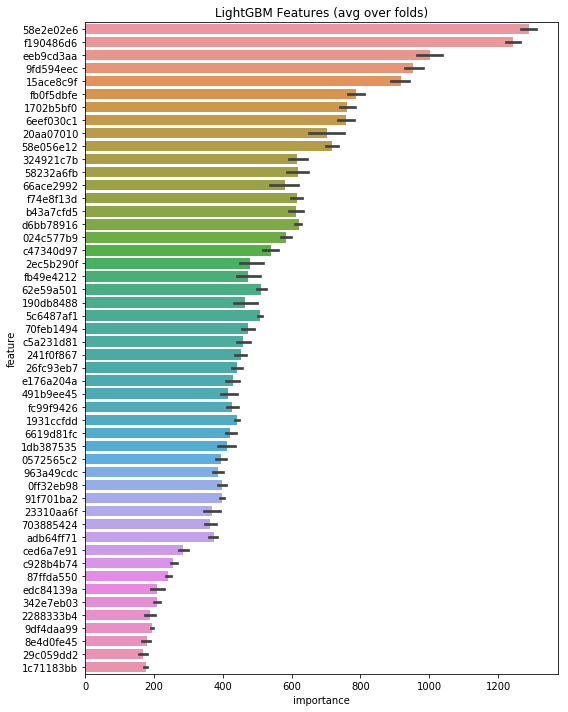

In [13]:
cols = all_feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = all_feature_importance_df.loc[all_feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", 
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# To DataFrame
sub_preds = pd.DataFrame.from_dict(multi_seed_pred).replace(0,0.000001)
del multi_seed_pred; gc.collect();

In [14]:
# Take Mean over Seed prediction
mean_sub = np.expm1(sub_preds.mean(axis=1).rename(target_var))
mean_sub.index = test_index

# Submit
mean_sub.to_csv('mean_sub_ep{}_sc{}.csv'.format(optimal_rounds,round(best_cv_score,5))
            ,index = True, header=True)
mean_sub.head()

ID
000137c73    2.028573e+06
00021489f    2.065039e+06
0004d7953    2.169284e+06
00056a333    7.208517e+06
00056d8eb    2.303841e+06
Name: target, dtype: float64